## Spectral analysis plot
##### only uses the two transects that cross the filament

In [1]:
# loading packages/toolkits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xarray as xr
import xrft
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
import os
from collections import OrderedDict
from itertools import cycle
import cmocean
import cmocean.cm as cmo

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
# this loads a colormap (thermal) and then cuts off the end (5%) so that it isn't as dark
lightthermal = cmocean.tools.crop_by_percent(cmo.thermal, 5, which='min', N=None)

# making some default settings for plot fontsizes
#matplotlib.get_configdir()
plt.style.use('/Users/North/.matplotlib/manuscript.mplstyle')

# where to get the data and save the figures
os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela") # need to set working directory to get .nc file access
sadcp_nc_dir = './netcdf_files/'
figure_dir = './figures/paper/'


In [13]:
def read_in_sadcp(transect_name):
    # read in netcdf files for a particular transect
    sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_'+transect_name+'.nc')) 
    # fix the way the coordinates are set up
    sadcp_transects_xkm = sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return sadcp_transects_xkm

def xrft_mat(ds,depth_range):
    # make xrft work for multiple series in xarray dataset format
    # dim is axis of data-series along which spectra is calculated
    # removed shift=True, because this is set to False when real~=False
    # setup to be similar to pyspec analysis
    # note that the dataarray (ds) is limited to the depth_range, and the spectra are applied along the distance dimension (x_m)
    psd_xrft_t = xrft.power_spectrum(ds.sel(z=depth_range).dropna('x_m').drop(('x_km','lat','lon','time','time_secs')).squeeze(),
                                     dim=['x_m'], real='x_m', window=True, detrend='linear')
    # only want half the spectra
    psd_xrft_t = psd_xrft_t.where(psd_xrft_t['freq_x_m']>0).dropna('freq_x_m')
    psd_xrft_t = psd_xrft_t.rename({'freq_x_m': 'freq_m'})

    return psd_xrft_t

def add_second_axis(ax1):
    """ Add a x-axis at the top of the spectra figures 
    from: https://nbviewer.jupyter.org/github/crocha700/dp_spectra/blob/master/adcp/plot_adcp_spectra.ipynb
    """
    ax2 = ax1.twiny() 
    ax2.set_xscale('log')
    ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
    # !! Assumes k is in cycles per unit or cpm, not radians per unit; if the latter, l = 2pi/k
    lp=np.array([1e5,1e4,7.5e3,5e3,2.5e3,1e3,5e2,2e2,1e2,50,20,10,5,2,1],dtype='int') # use km not m
    kp = 1/(lp*1e3) # in m
    ax2.set_xticks(kp)
    ax2.set_xticklabels(lp) 
    ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
    plt.xlabel('Wavelength [km]')
    # hide unwanted minor ticks - https://stackoverflow.com/questions/20396236/matplotlib-how-to-set-ticks-of-twinned-axis-in-log-plot
    ax2.tick_params(axis='x',which='minor',top=False); #REMOVE 'MINOR' TICKS
    return ax2

def plot_loglog_slope(ax_in,slope_power,xlim,ylim,line_color='#cccccc'):
    # adding lines with a slope of slope_power to a log-log plot
    xlim1,xlim2 = ax_in.get_xlim() # messes up axes
    ylim1,ylim2 = ax_in.get_ylim()
    for si in range(slope_power.shape[0]):
        factor = np.max(xlim**(slope_power[si])/np.max(ylim)) # start line 3/4 of way over
        ax_in.loglog(xlim, xlim**(slope_power[si])/factor,'--','lw',.5,color=line_color,label='_nolegend_',zorder=0)
    ax_in.set_xlim(xlim1,xlim2) # need to reset this after ax_in.get_xlim()
    ax_in.set_ylim(ylim1,ylim2)
    
def spectral_slope(k,E,kmin,kmax,Estart): # rpn,stdE):
    # fitting a slope to data in a loglog plot
    ''' compute spectral slope in log space in
        a wavenumber subrange [kmin,kmax],
        m: spectral slope; mm: uncertainty'''
    # modified version of pyspec function rpn 25.03.2020

    stdE = np.std(E) # rpn
    fr = np.where((k>=kmin)&(k<=kmax))

    ki = np.matrix((np.log10(k[fr]))).T
    Ei = np.matrix(np.log10(np.real(E[fr]))).T
    dd = np.matrix(np.eye(ki.size)*((np.abs(np.log10(stdE)))**2))

    G = np.matrix(np.append(np.ones((ki.size,1)),ki,axis=1))
    Gg = ((G.T*G).I)*G.T
    m = Gg*Ei
    mm = np.sqrt(np.array(Gg*dd*Gg.T)[1,1])
    yfit = np.array(G*m)
    m = np.array(m)[1]
    
    y_start = 10
    factor = np.max(np.array((kmin,kmax))**(m)/np.max(Estart)) # start line 3/4 of way over
    y4plot = np.array((kmin,kmax))**(m)/factor
    
    return m, mm, y4plot

def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    rpn: copied on 25.9.2010 from: https://gist.github.com/tacaswell/9643166
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    **kwargs)
        
def psd_plot_mean(psd_xrft,var_name,label_in,ax,sn,cpkm_cpm = 'cpm',lcolor=None,add_loglog_line=True,
                 add_error_shade=True,alpha=None):
    # plot XRFT spectra - 
    # set x-axis be cpkm and y-axis to (m/s)^2 / cpkm
    if cpkm_cpm == 'cpkm': factor = 1e3
    if cpkm_cpm == 'cpm': factor = 1
    nbins_spec_av = 10

    # smooth spectra by binning along the x-axis in "nbins_spec_av" bins
    wavenumKE_hat, psdKE_hat =  spec.avg_per_decade(psd_xrft[var_name].freq_m,
                                                    (psd_xrft[var_name]).values,
                                                    nbins=nbins_spec_av)
    # compute 95% confidence interval for 1D spectra with chi^2 distribution, with 2*sn degrees of freedom
    # sn is e.g. the number of depths or timesteps that (psd_xrft[var_name]).values has been averaged over
    uEl,uEu = spec.spec_error(psdKE_hat/(2*factor), sn=sn, ci=0.95) # using txYC is too high for sn
    p = ax.loglog((wavenumKE_hat*factor),psdKE_hat/(2*factor), alpha=alpha,lw=2,label=label_in,color=lcolor)        
    # times 1e3 to make x cpkm
    if add_error_shade:
        ax.fill_between((wavenumKE_hat*factor),uEl,uEu, alpha=0.1,color=p[-1].get_color(), label=None)

    # power spectral units
    ax.set_ylabel(r'Power spectral density [m$^2$ s$^{-2}$/'+cpkm_cpm+']')
    ax.set_xlabel('Along-track wavenumber ['+cpkm_cpm+']')
    ax.set_title("")
    return p

In [4]:
# ====== Load in data

# ====== load SADCP and Scanfish data
# each transect is saved in it's own netcdf file (.nc); load one at a time as an xarray Dataset (e.g., see print out below) 
# then combine Datasets into an "OrderedDictionary", with each transect name referencing its Dataset
sadcp_transects_1km = OrderedDict() # Preallocate output dictionary
sadcp_transects_1km['WestwardFromUpwellTransect1'] = read_in_sadcp('WestwardFromUpwellTransect1').reset_index('xy').swap_dims({'xy':'x_m'})
#sadcp_transects_1km['ToCapetown1'] = read_in_sadcp('ToCapetown1').reset_index('xy').swap_dims({'xy':'x_m'})
#sadcp_transects_1km['AwayFromFilament1'] = read_in_sadcp('AwayFromFilament1').reset_index('xy').swap_dims({'xy':'x_m'})
sadcp_transects_1km['FullScanTransect1'] = read_in_sadcp('FullScanTransect1').reset_index('xy').swap_dims({'xy':'x_m'})
# change distance along transect from m to km
for key in sadcp_transects_1km:
    sadcp_transects_1km[key] = (sadcp_transects_1km[key].assign_coords(x_km=sadcp_transects_1km[key].x_m/1e3))

sadcp_transects_1km #['FullScanTransect1'] # this will print the contents of the last dataset, i.e. the transect 'FullScanTransect1' 

OrderedDict([('WestwardFromUpwellTransect1',
              <xarray.Dataset>
              Dimensions:     (x_m: 225, z: 100)
              Coordinates:
                * z           (z) float32 -17.54 -25.54 -33.54 -41.54 ... -793.5 -801.5 -809.5
                * x_m         (x_m) float64 0.0 1e+03 2e+03 ... 2.22e+05 2.23e+05 2.24e+05
                  lat         (x_m) float64 -25.89 -25.89 -25.9 -25.9 ... -26.71 -26.71 -26.71
                  lon         (x_m) float64 13.08 13.07 13.06 13.06 ... 11.06 11.05 11.04
                  time        (x_m) datetime64[ns] 2016-11-27T05:02:05 ... 2016-11-27T17:25...
                  time_secs   (x_m) float64 1.48e+18 1.48e+18 1.48e+18 ... 1.48e+18 1.48e+18
                  x_km        (x_m) float64 0.0 1.0 2.0 3.0 4.0 ... 221.0 222.0 223.0 224.0
              Data variables:
                  trajectory  int32 ...
                  vship       (x_m) float64 ...
                  v           (x_m, z) float64 ...
                  uship     

In [5]:
#### ===== Get ADCP spectra with XRFT
# average spectra over these depths; slice means include all depths between -19m and -50m
depth_range= slice(-19,-50)

# looping through transects to get each transects depth-averaged mean, and the mean of all transects and all depths of interest
sik = 0
psd_xrft_single= OrderedDict() # Preallocate output dictionary
for key in sadcp_transects_1km:
    # run XRFT on each velocity component, for selected depth range; creates a dataset with the spectra as the variables (dataarrays)
    psd_xrft = xr.Dataset({'u': xrft_mat(sadcp_transects_1km[key].u,depth_range),
                           'v': xrft_mat(sadcp_transects_1km[key].v,depth_range),
                           'across': xrft_mat(sadcp_transects_1km[key].across,depth_range),
                           'along':  xrft_mat(sadcp_transects_1km[key].along,depth_range)})
    # add kinetic energy; this adds ke as a new variable (dataarray) to the dataset psd_xrft
    psd_xrft['ke']= ((psd_xrft.u+psd_xrft.v))
    # combine spectra for averaging
    if sik == 0: psd_xrft_all = psd_xrft
    else: # interpolate to get consistent frequencies before concatenating 
        if psd_xrft.freq_m.size > psd_xrft_all.freq_m.size: 
            psd_xrft = psd_xrft.interp(freq_m=psd_xrft_all.freq_m)
        else:
            psd_xrft_all = psd_xrft_all.interp(freq_m=psd_xrft.freq_m)
        # concat combines the dataarrays (e.g., 'u' or 'v') into one dataarray with a new 
        # dimension "transect" (i.e. 'u' spectra of all transects)
        psd_xrft_all = xr.concat((psd_xrft_all,psd_xrft),dim='transect')
    # psd_xrft_single contains as many datasets as transects, and each dataset is the spectra (not-averaged) for each transect and each depth 
    psd_xrft_single[key] = psd_xrft+0 # so it makes a copy not linked
    
    sik = sik+1

# helmholtz decomp of mean spectra - for consistency with other setups
# mean is taken across dimensions "transect" and "z", so average across all transects and all depths
psi_rot, phi_div = helm.spec_helm_decomp(psd_xrft_all.freq_m, psd_xrft_all.mean(('transect','z')).across, 
                                         psd_xrft_all.mean(('transect','z')).along)
# add psi_rot and phi_div to dataset by making a copy of mean "across" variable
psd_xrft_all['psi_rot'] = psd_xrft_all.mean(('transect','z')).across.copy(data=psi_rot)
psd_xrft_all['phi_div'] = psd_xrft_all.mean(('transect','z')).across.copy(data=phi_div)
psd_xrft_all # the resulting dataset of spectra for the various velocity components and the average decomposed components

<xarray.Dataset>
Dimensions:           (freq_m: 112, transect: 2, z: 4)
Coordinates:
  * z                 (z) float32 -25.54 -33.54 -41.54 -49.54
  * freq_m            (freq_m) float64 4.444e-06 8.889e-06 ... 0.0004978
    freq_x_m_spacing  (transect) float64 4.444e-06 4.386e-06
Dimensions without coordinates: transect
Data variables:
    u                 (transect, z, freq_m) float64 dask.array<chunksize=(1, 1, 112), meta=np.ndarray>
    v                 (transect, z, freq_m) float64 dask.array<chunksize=(1, 1, 112), meta=np.ndarray>
    across            (transect, z, freq_m) float64 dask.array<chunksize=(1, 1, 112), meta=np.ndarray>
    along             (transect, z, freq_m) float64 dask.array<chunksize=(1, 1, 112), meta=np.ndarray>
    ke                (transect, z, freq_m) float64 dask.array<chunksize=(1, 1, 112), meta=np.ndarray>
    psi_rot           (freq_m) float64 507.0 280.5 224.1 ... 0.08868 0.2086
    phi_div           (freq_m) float64 -197.5 12.55 -20.78 ... 0.1145 0.1264

##### 3. ADCP KE Spectra

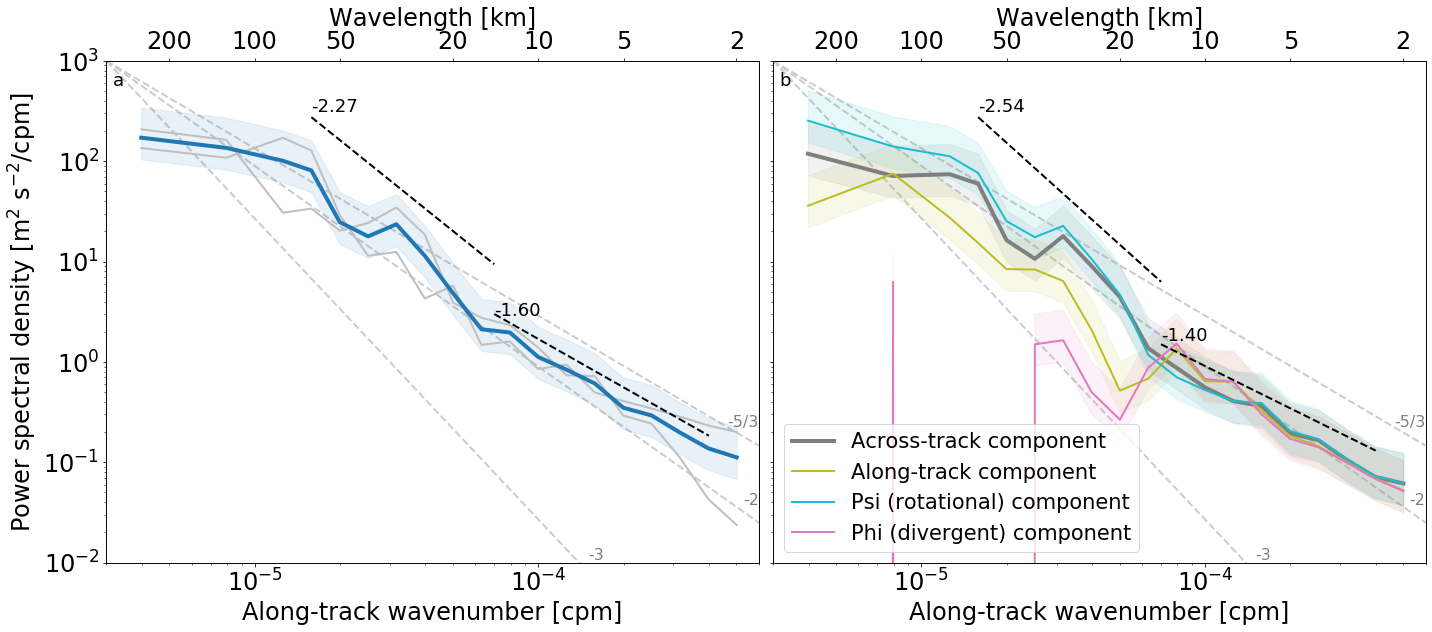

In [15]:
# plotting average spectra from ADCP
                                                                                 
nrows, ncols =  2,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting overall figure size 
axs = [None]*nrows*ncols
ylim = (1e-2,1e3) # axs[si].get_ylim()
xlim = (3e-6,6e-4) # axs[si].get_xlim()

# === plot depth-averaged kinetic energy spectra of each transect
si = 0   
axs[si] = plt.subplot(nrows, ncols, si+1)
# looping to plot the depth-averaged (.mean('z')) KE spectra of each transect (grey line); note binning along x-axis in psd_plot_mean
for key in psd_xrft_single: 
    psd_plot_mean(psd_xrft_single[key].mean(('z')),'ke',key,axs[si],psd_xrft_single[key].z.size,lcolor='0.75',
                    add_error_shade=False) # this included averaging spectra over the depth range

# plot mean of all transects by averaging over selected depths and transects at once; includes shading in 95% confidence interval
p = psd_plot_mean(psd_xrft_all.mean(('z','transect')),'ke','Average',axs[si],psd_xrft_all.transect.size*psd_xrft_all.z.size,
                  lcolor=plt.cm.tab10(0.))
p[-1].set_linewidth(4) # set the linewidth to be thicker
#axs[si].text(0.98,0.90,('Depths: %i ' %sadcp_transects_1km[key].z.sel(z=depth_range)[0] + 
#                       'to %i m' %sadcp_transects_1km[key].z.sel(z=depth_range)[-1]),
#            transform=axs[si].transAxes,horizontalalignment='right', verticalalignment='top',size=16)
# fitting a slope to the spectra (after binning along x)
slope_lim = np.array((p[0].get_xdata()[3], 7.0e-5)) # x-axis range of slope
m,mm,y4plot =  spectral_slope(p[0].get_xdata(),p[0].get_ydata(),
                      slope_lim[0],slope_lim[1],275)
axs[si].plot(slope_lim, y4plot,'--','lw',.5,label='_nolegend_',color='k')
axs[si].text(slope_lim[0],y4plot[0]+150,'%.2f' % m, verticalalignment='top',size=18)

slope_lim = np.array((7.0e-05, 4.0e-4))
m,mm,y4plot =  spectral_slope(p[0].get_xdata(),p[0].get_ydata(),
                      slope_lim[0],slope_lim[1],3)
axs[si].plot(slope_lim, y4plot,'--','lw',.5,label='_nolegend_',color='k')
axs[si].text(slope_lim[0],y4plot[0]+1,'%.2f' % m, verticalalignment='top',size=18)

# adding lines and corresponding label showing standard slopes
axs[si].text(6e-4,3e-1,'-5/3',alpha=0.5, verticalalignment='top',horizontalalignment='right',size=16)
axs[si].text(6e-4,5e-2,'-2',alpha=0.5, verticalalignment='top',horizontalalignment='right',size=16)
axs[si].text(1.5e-4,1e-2,'-3',alpha=0.5, verticalalignment='bottom',horizontalalignment='left',size=16)
plot_loglog_slope(axs[si],np.array((-5/3,-2,-3)),xlim,ylim)
axs[si].set_ylim(ylim)
axs[si].set_xlim(xlim)

# add wavelength on top axis
add_second_axis(axs[si])

# === plot across/along track component of mean (depth and transect) spectra and the helmholtz decomposition
si = 1
axs[si] = plt.subplot(nrows, ncols, si+1)
p = psd_plot_mean(psd_xrft_all.mean(('z','transect')),'across','Across-track component',axs[si],
                  psd_xrft_all.transect.size*psd_xrft_all.z.size,lcolor=plt.cm.tab10(0.7))
p[-1].set_linewidth(4)
p = psd_plot_mean(psd_xrft_all.mean(('z','transect')),'along','Along-track component',axs[si],
                  psd_xrft_all.transect.size*psd_xrft_all.z.size, lcolor=plt.cm.tab10(0.8))
p[-1].set_linewidth(4)
# now the rotational and divergent components from the helmholtz decomposition
p1 = psd_plot_mean(psd_xrft_all,'psi_rot','Psi (rotational) component',axs[si],psd_xrft_all.transect.size*psd_xrft_all.z.size,
                   lcolor=plt.cm.tab10(0.9))
p[-1].set_linewidth(2)
p = psd_plot_mean(psd_xrft_all,'phi_div','Phi (divergent) component',axs[si],psd_xrft_all.transect.size*psd_xrft_all.z.size,
                  lcolor=plt.cm.tab10(0.6))
p[-1].set_linewidth(2)
axs[si].legend(loc='lower left')
axs[si].set_ylim(ylim)
axs[si].set_xlim(xlim)

# adding lines showing standard slopes
axs[si].text(6e-4,3e-1,'-5/3',alpha=0.5, verticalalignment='top',horizontalalignment='right',size=16)
axs[si].text(6e-4,5e-2,'-2',alpha=0.5, verticalalignment='top',horizontalalignment='right',size=16)
axs[si].text(1.5e-4,1e-2,'-3',alpha=0.5, verticalalignment='bottom',horizontalalignment='left',size=16)
plot_loglog_slope(axs[si],np.array((-5/3,-2,-3)),xlim,ylim)

# fitting a slope to the Psi spectra (after binning along x)
slope_lim = np.array((p1[0].get_xdata()[3], 7.0e-5))
m,mm,y4plot =  spectral_slope(p1[0].get_xdata(),p1[0].get_ydata(),
                      slope_lim[0],slope_lim[1],275)
axs[si].plot(slope_lim, y4plot,'--','lw',.5,label='_nolegend_',color='k')
axs[si].text(slope_lim[0],y4plot[0]+150,'%.2f' % m, verticalalignment='top',horizontalalignment='left',size=18)

slope_lim = np.array((7.0e-05, 4.0e-4))
m,mm,y4plot =  spectral_slope(p1[0].get_xdata(),p1[0].get_ydata(),
                      slope_lim[0],slope_lim[1],1.5)
axs[si].plot(slope_lim, y4plot,'--','lw',.5,label='_nolegend_',color='k')
axs[si].text(slope_lim[0],y4plot[0],'%.2f' % m, verticalalignment='bottom',horizontalalignment='left',size=18)

# adding letter labels to subplots
label_axes(fig,loc=(0.01,0.95),labels=np.array(('a','','b','','','','','','')),size=18)
ax2= add_second_axis(axs[si]) # wavelength on top
#ax2.set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_ADCP_Spectra_XRFT_from_2_transects.pdf'
fig.savefig(figname, orientation='landscape',bbox_inches='tight')

(0, 4)

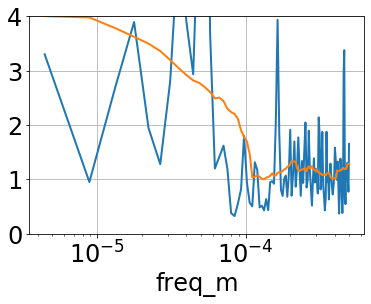

In [20]:
# check ratio of along-track and across-track componenets
(psd_xrft_all.across.mean(('z','transect'))/psd_xrft_all.along.mean(('z','transect'))).plot(xscale='log')
(psd_xrft_all.across.mean(('z','transect'))/psd_xrft_all.along.mean(('z','transect'))).rolling(freq_m=24,center=True,min_periods=1).mean(skipna=True).plot(xscale='log')
plt.grid()
plt.ylim(0,4)